# EDA (Análise Exploratória dos Dados)

Este notebook tem o objetivo de entender e analisar os datasets de maneira univariada e multivariada (em relação ao target). Além disso, será criada a variável target, a partir das definições propostas.

**Sumário**
1. Importação das bibliotecas
2. Construção do Target
3. Separação entre treino e teste (dados de validação)
4. Análise univariada
5. Análise multivariada
<br><br>
---

# 1. Importação das bibliotecas

- pandas: Manipulação dos dados
- numpy: Manipulação numérica
- DataUtils: Classe criada para abstrair boiler plates
- matplotlib e seaborn: Visualização dos dados
- sklearn: Separação em treino e teste

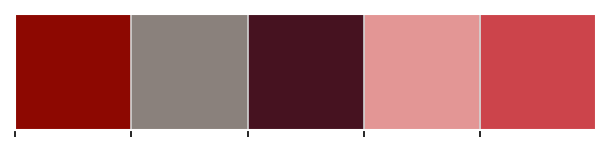

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from src.eda_utils import *


pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
mpl.style.use('ggplot')
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['grid.color']          = 'lightgray'
mpl.rcParams['xtick.color']         = 'black'
mpl.rcParams['ytick.color']         = 'black'
mpl.rcParams['axes.grid']           = True
mpl.rcParams['figure.dpi']          = 150

# Palette
instyle_palette = ['#8d0801', '#8a817c', '#461220', '#e39695', '#cc444b']
sns.set_palette(sns.color_palette(instyle_palette))
sns.palplot(sns.color_palette(instyle_palette))

<br>

---
<br>

### 2. Construção do target

Para este desafio, definiu-se que um cliente deve ser considerado inadimplente quando o pagamento ocorrer com 5 dias ou mais de atraso em relação à data de vencimento. Como essa classificação não está presente no dataset, o target deve ser construído a partir das variáveis disponíveis.

Assim, adotaremos a seguinte regra:

- TARGET = 1 → quando DATA_PAGAMENTO - DATA_VENCIMENTO ≥ 5
- TARGET = 0 → caso contrário



In [2]:
base_pag = DataUtils.read_data(file='processed/base_pagamentos_desenvolvimento.xlsx', file_type='xlsx')

base_pag.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99
1,1661240395903230976,2018-08-01,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99
2,1661240395903230976,2018-08-01,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99
3,1661240395903230976,2018-08-01,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99
4,1661240395903230976,2018-08-01,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99


O primeiro passo passo para a construção é a comparação entre os dias de atraso, dessa forma, utilizaremos as colunas DATA_PAGAMENTO e DATA_VENCIMENTO para compor esta nova coluna.

In [3]:
base_pag['DIAS_ATRASO'] = base_pag['DATA_PAGAMENTO'].dt.day - base_pag['DATA_VENCIMENTO'].dt.day

base_pag.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIAS_ATRASO
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0
1,1661240395903230976,2018-08-01,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,1
2,1661240395903230976,2018-08-01,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,1
3,1661240395903230976,2018-08-01,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,6
4,1661240395903230976,2018-08-01,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0


Com os dias de atraso definidos, podemos então, construir o **target** a partir da regra proposta.

In [4]:
base_pag['INADIMPLENTE'] = np.where(base_pag['DIAS_ATRASO'] >= 5, 1, 0)

base_pag.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,INADIMPLENTE
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,0
1,1661240395903230976,2018-08-01,2018-08-19,2018-09-11,2018-09-10,17758.21,6.99,1,0
2,1661240395903230976,2018-08-01,2018-08-26,2018-09-18,2018-09-17,17431.96,6.99,1,0
3,1661240395903230976,2018-08-01,2018-08-30,2018-10-11,2018-10-05,1341.00,6.99,6,1
4,1661240395903230976,2018-08-01,2018-08-31,2018-09-20,2018-09-20,21309.85,6.99,0,0


---

### 3. Separação entre treino e teste (dados de validação)

Com o target construído, podemos explorar os dados e ver como se relacionam aos mesmos. Entretanto, para uma garantir a integridade da Análise, bem como, evitar vazamentos para o modelos, devemos separar os dados em treino e teste. 

Para essa separação, utilizaremos o conceito de separação Split of Out Time. 

- Adicionar mais infos dps, inclusive sobre a ordenação do dataset

In [5]:
base_pag.sort_values('SAFRA_REF', inplace=True)

In [6]:
train, test = np.split(base_pag, [int(.80 * len(base_pag))])
train['SET'] = 'train'
test['SET'] = 'test'

In [7]:
print(f"Taxa de inadimplente conjunto de treino:\n {train['INADIMPLENTE'].value_counts(normalize=True)}.")
print()
print(f"Taxa de inadimplente conjunto de teste:\n {test['INADIMPLENTE'].value_counts(normalize=True)}.")

Taxa de inadimplente conjunto de treino:
 INADIMPLENTE
0    0.925643
1    0.074357
Name: proportion, dtype: float64.

Taxa de inadimplente conjunto de teste:
 INADIMPLENTE
0    0.927017
1    0.072983
Name: proportion, dtype: float64.


Observamos taxas semelhantes de inadimplência em ambos os conjuntos, o que mostra que em termos de representativade, o split foi bem sucedido. Além disso, nota-se o desbalanceamento da variável alvo.

In [8]:
print(f'O conjunto de treino tem {train.shape[0]} linhas e {train.shape[1]} colunas')
print(f'O conjunto de teste tem {test.shape[0]} linhas e {test.shape[1]} colunas')

O conjunto de treino tem 61931 linhas e 10 colunas
O conjunto de teste tem 15483 linhas e 10 colunas


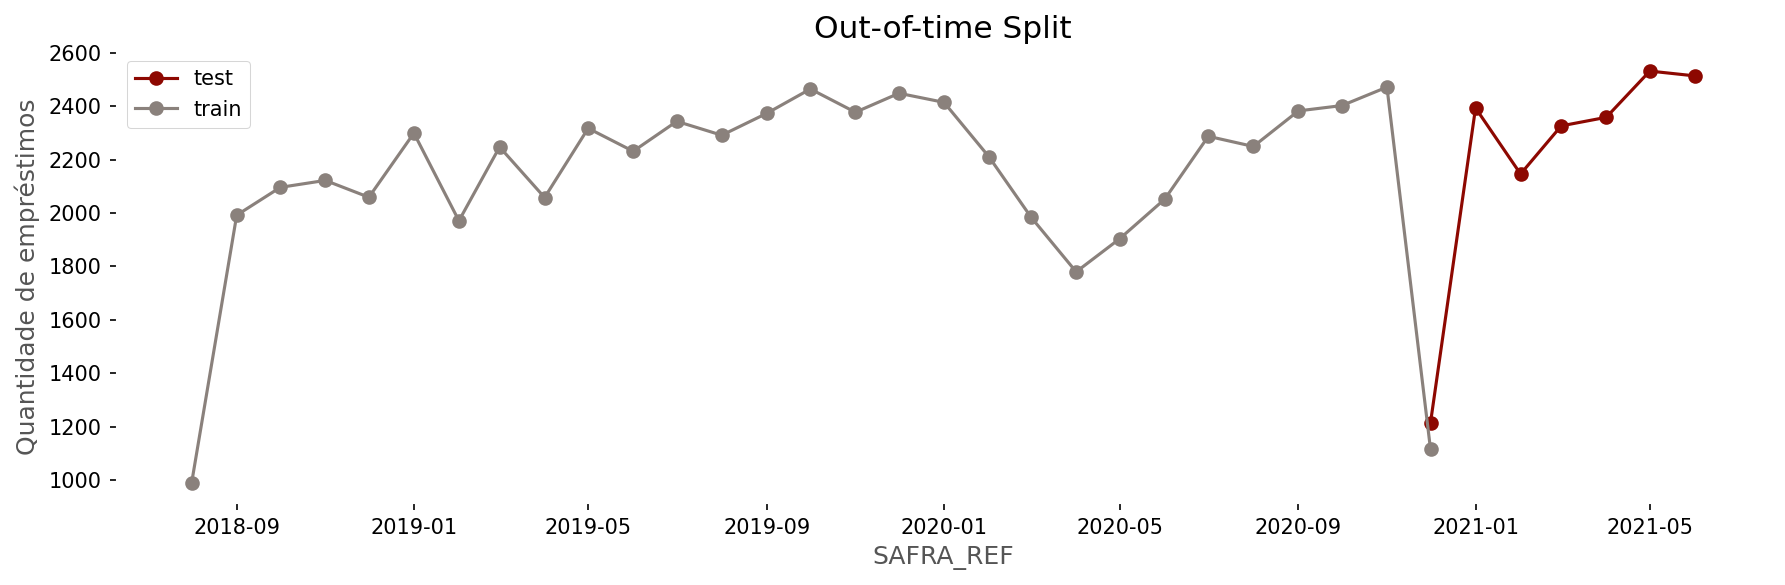

In [9]:
train_test = pd.concat([train, test])
# se você quiser a TAXA de inadimplência (muito mais útil):
train_test = (
    train_test
    .groupby(['SAFRA_REF', 'SET'])['INADIMPLENTE']
    .count()
    .reset_index()
)


fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Out-of-time Split', fontsize=15)

for set_name, df_set in train_test.groupby('SET'):
    ax.plot(df_set['SAFRA_REF'], df_set['INADIMPLENTE'], marker='o', label=set_name)

ax.set_xlabel('SAFRA_REF')
ax.set_ylabel('Quantidade de empréstimos')
ax.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


- O split de Out-of-Time foi realizado com sucesso
- Percebemos um leve declínio de transações nos períodos de 2020-01 a 2020-05 e no final de 2020.

---

### 4. Análise univariada

#### **4.1 Base de pagamentos**

In [10]:
train.describe().T

,count,mean,min,25%,50%,75%,max,std
ID_CLIENTE,61931.0,4658828322574588928.0,8784237149961904.0,2369364892942408192.0,4795152981525833728.0,6969348581033924608.0,9206030810342980608.0,2666994892077210112.0
SAFRA_REF,61931,2019-10-07 01:34:29.690461952,2018-08-01 00:00:00,2019-03-01 00:00:00,2019-10-01 00:00:00,2020-05-01 00:00:00,2020-12-01 00:00:00,NaN
DATA_EMISSAO_DOCUMENTO,61931,2019-10-21 21:46:32.120262912,2018-08-17 00:00:00,2019-03-27 00:00:00,2019-10-21 00:00:00,2020-05-24 00:00:00,2020-12-31 00:00:00,NaN
DATA_PAGAMENTO,61931,2019-11-14 04:40:52.820073984,2018-06-19 00:00:00,2019-04-22 00:00:00,2019-11-12 00:00:00,2020-06-16 00:00:00,2021-09-01 00:00:00,NaN
DATA_VENCIMENTO,61931,2019-11-14 06:20:19.667048960,2017-11-27 00:00:00,2019-04-22 00:00:00,2019-11-12 00:00:00,2020-06-16 00:00:00,2027-03-31 00:00:00,NaN
VALOR_A_PAGAR,60997.0,44142.019737,0.1,17963.96,33256.0,58091.97,4400000.0,44897.167852
TAXA,61931.0,6.785676,4.99,5.99,5.99,6.99,11.99,1.784871
DIAS_ATRASO,61931.0,0.339571,-30.0,0.0,0.0,0.0,30.0,4.878655
INADIMPLENTE,61931.0,0.074357,0.0,0.0,0.0,0.0,1.0,0.262353


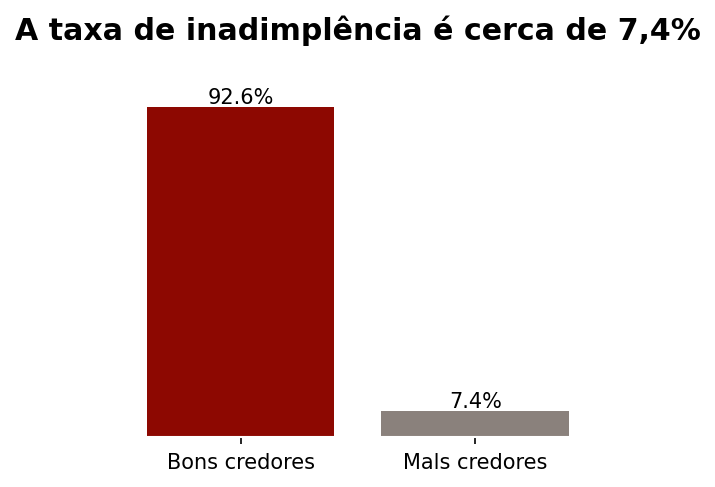

In [11]:
fig, ax = plt.subplots(figsize=(4, 3))

target_grouped = train.groupby(['INADIMPLENTE'])['INADIMPLENTE'].count().rename('count').reset_index()

target_grouped['pct'] = target_grouped['count'] / target_grouped['count'].sum() * 100

bars = ax.bar(x=target_grouped['INADIMPLENTE'], height=target_grouped['pct'], color=instyle_palette)
for bar, pct in zip(bars, target_grouped['pct']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{pct:.1f}%', ha='center', va='bottom')
ax.set_title('A taxa de inadimplência é cerca de 7,4%', pad=25, fontweight='bold')
ax.set_xticks(ticks=target_grouped['INADIMPLENTE'], labels=['Bons credores', 'Mals credores'])
ax.yaxis.set_visible(False)
ax.grid(False)

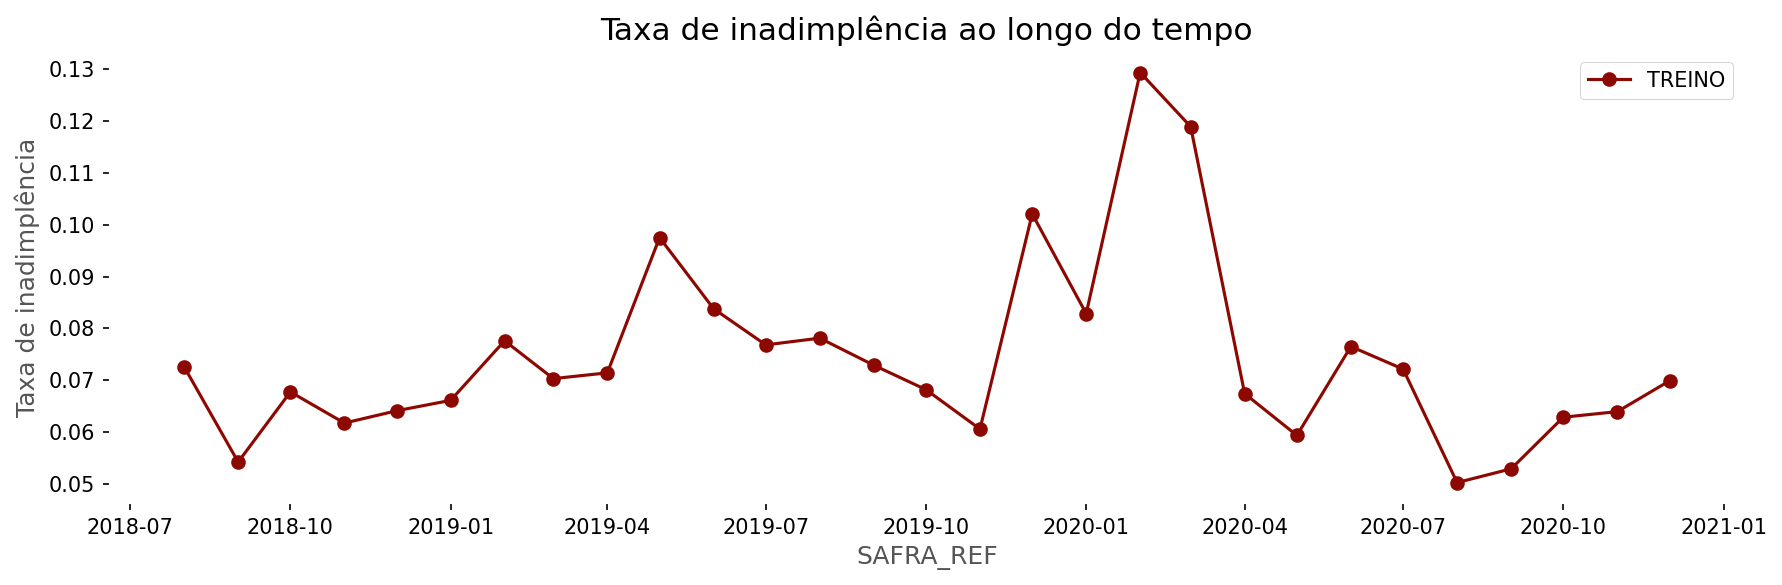

In [12]:
target_mean_train = (
    train
    .groupby('SAFRA_REF')['INADIMPLENTE']
    .mean()
    .reset_index(name='TARGET_MEAN')
)


fig, ax = plt.subplots(figsize=(12, 4))
plt.title('Taxa de inadimplência ao longo do tempo', fontsize=15)

ax.plot(
    target_mean_train['SAFRA_REF'],
    target_mean_train['TARGET_MEAN'],
    marker='o',
    label='TREINO'
)

ax.set_xlabel('SAFRA_REF')
ax.set_ylabel('Taxa de inadimplência')
ax.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

- Notamos um incremento nas taxas de inadimplência nos período do final de 2019 à Março de 2020.
- O pico de taxa de inadimplência ocorreu em Fevereiro de 2020, denotando quase que o dobro da média de taxa de inadimplência.

**4.1.2 Variáveis numéricas**

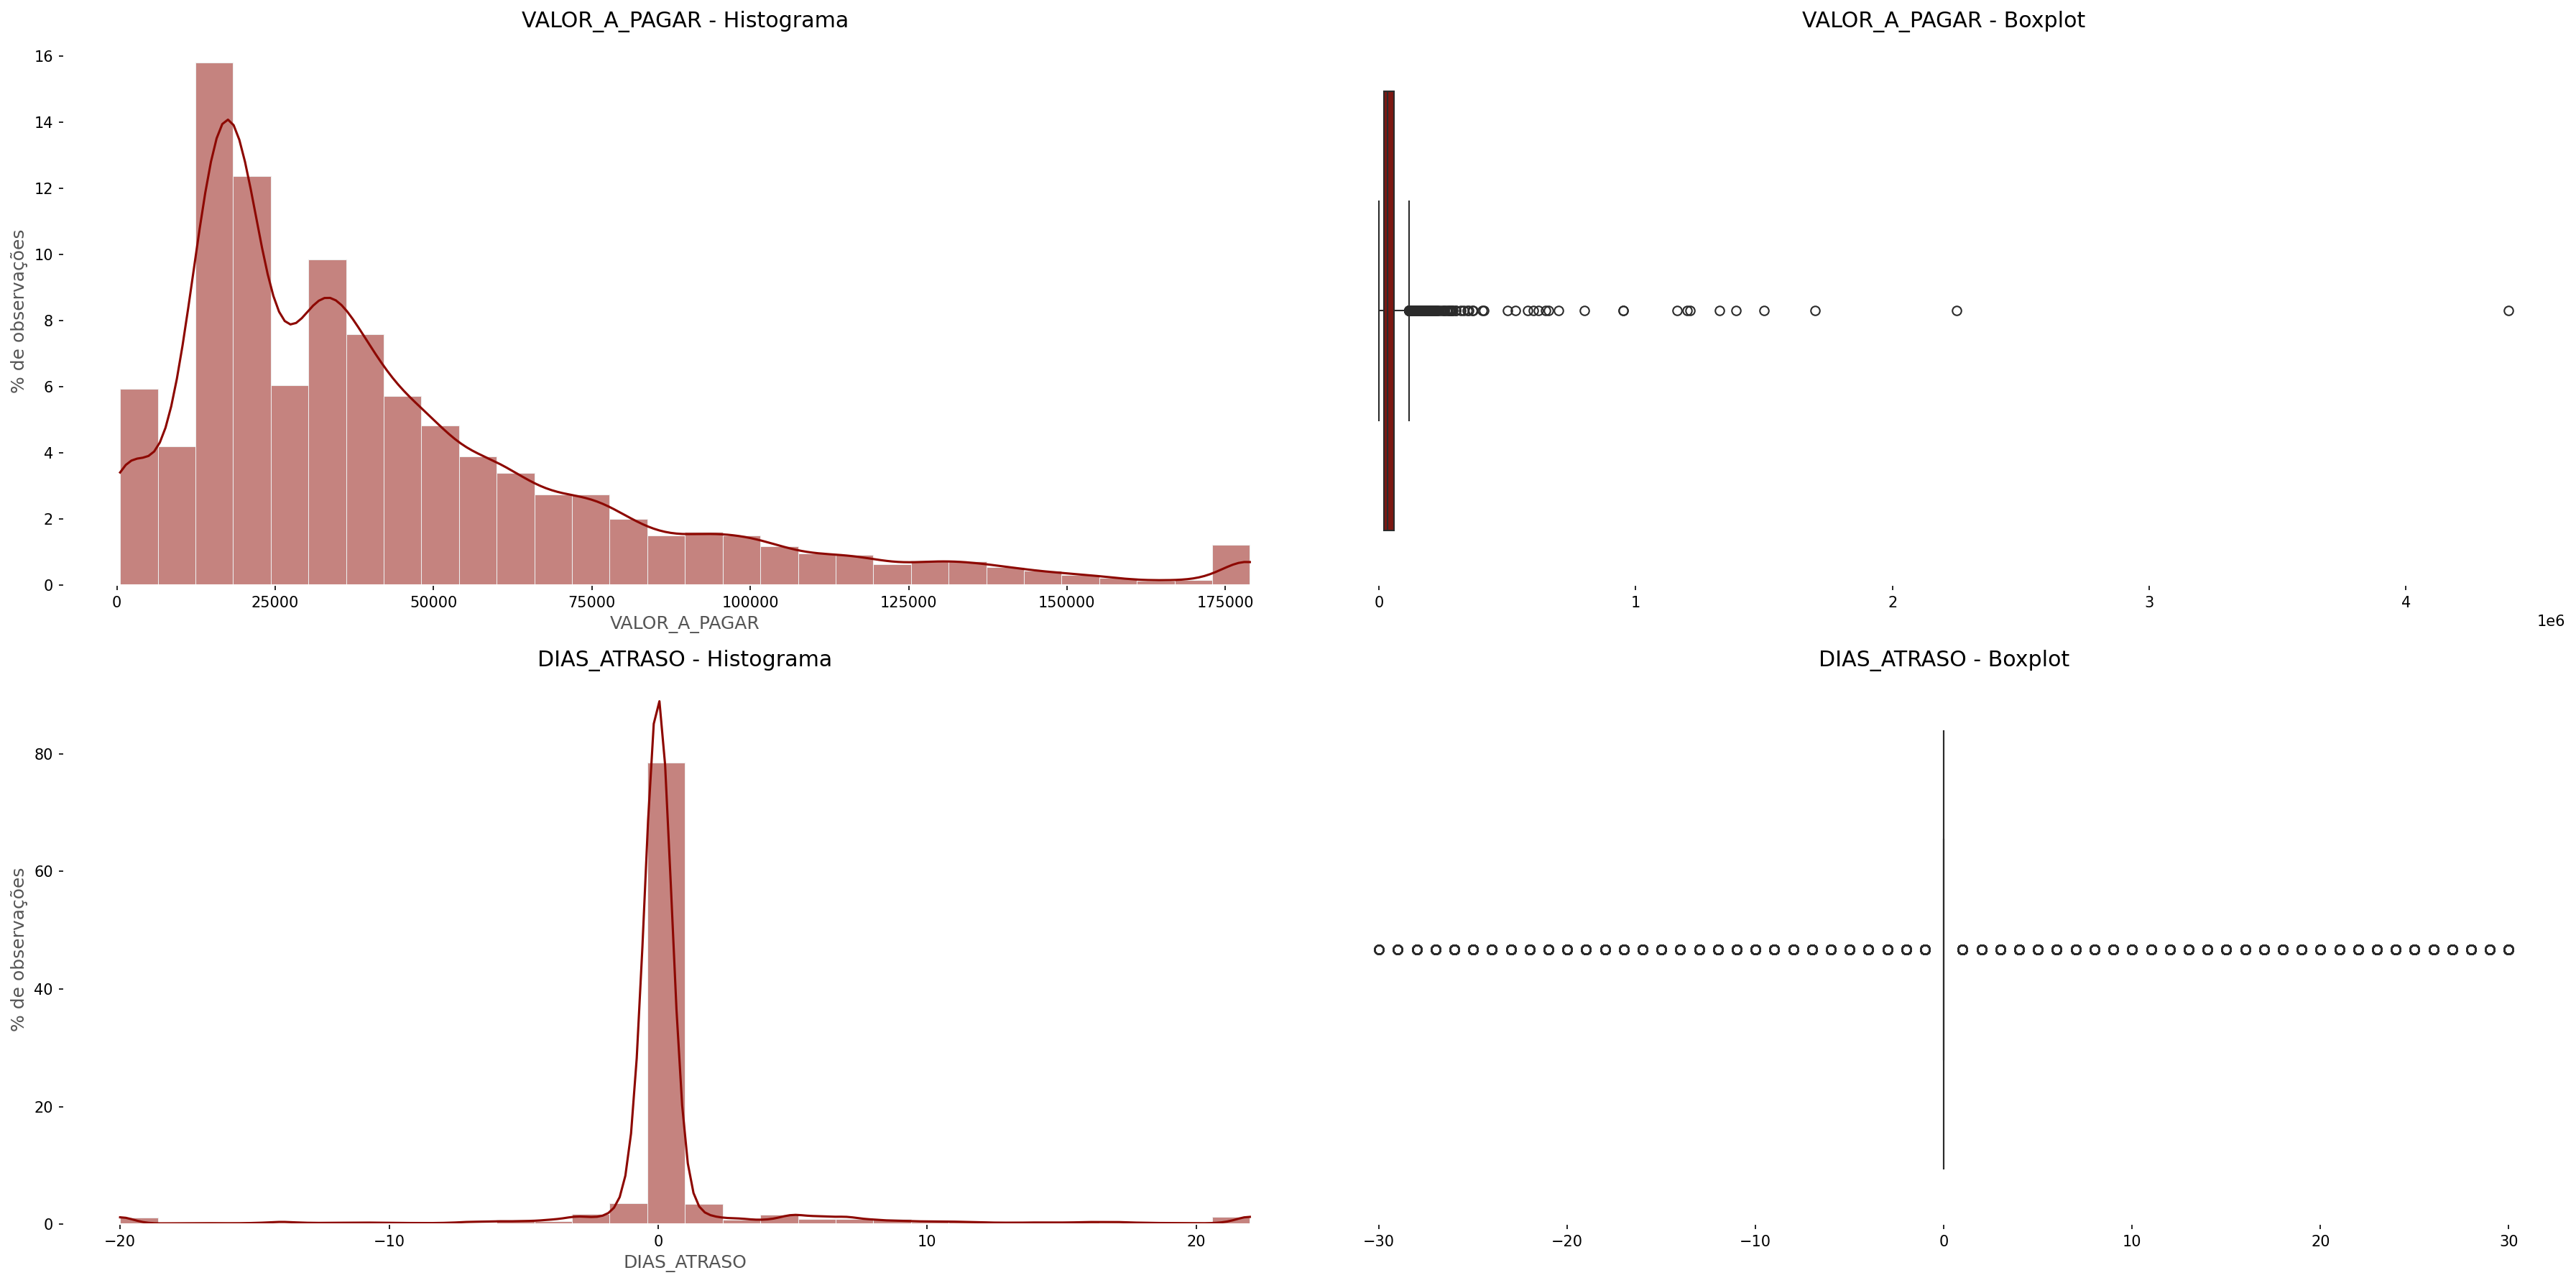

In [13]:
num_feats = ['VALOR_A_PAGAR', 'DIAS_ATRASO']

DataUtils.univariate_analysis_plots(train, num_feats, histplot=True, kde=True)

- Percebemos a presença de Outliers em todas as variáveis, entretanto, os valores a serem pagos se destacam nesse quesito. Apesar de existirem cobranças de mais de 4 milhões, cerca de 75% dos valores são até cerca de 58.000. Isso indica valores médios-altos, o que denota empresas ou contratos maiores. 
- Como já esperado, pagamentos adiantados e pontuais são a maioria, denotado pelo pico em torno de 0.


**4.1.3 Variáveis categóricas**

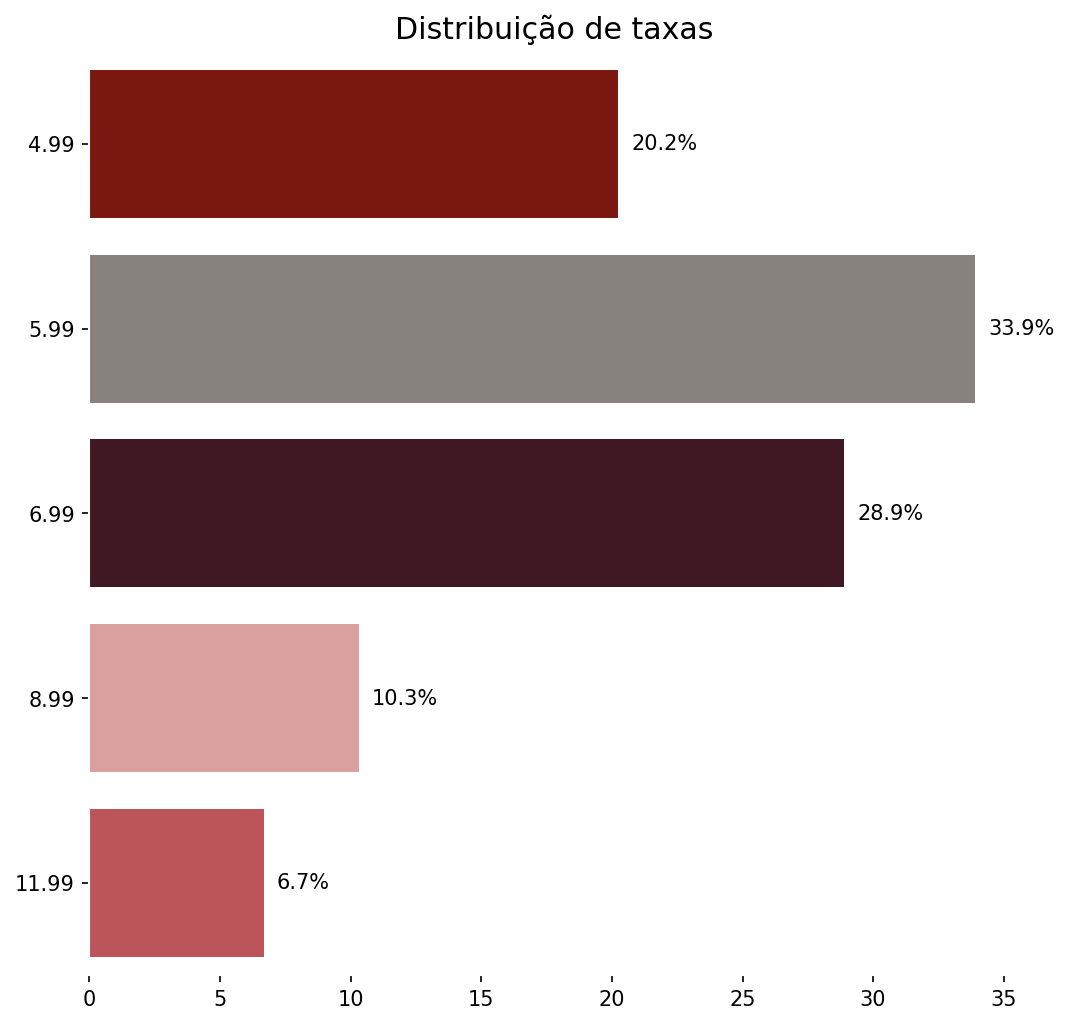

In [14]:
grouped = (
    train['TAXA']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)

grouped.columns = ['TAXA', 'pct']


fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(grouped, x='pct', y='TAXA', palette=instyle_palette, ax=ax, orient='h')
ax.set_title('Distribuição de taxas')
ax.set_xlabel('')
ax.set_ylabel('')


for bar in ax.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    ax.text(
        width + 0.5,          # um pouquinho pra direita da barra
        y,
        f"{width:.1f}%",
        va="center",
        ha="left",
        fontsize=10
    )

ax.grid(False)
plt.show()


- Percebemos que a Taxa de 5,99% é a mais presente no conjunto de treino. Ela representa aproxidamente 34% das taxas de transações de empréstimos. 
- Além disso, Quase 80% das taxas estão distríbuidas entre: 4,99%, 5,99%, 6,99%.

#### **4.2 Base cadastral**

Esta base só possui variáveis categóricas, dessa forma, torna-se desnecessário a análise de variáveis numéricas.

In [15]:
base_cadastral = DataUtils.read_data(file='processed/base_cadastral.xlsx', file_type='xlsx')

In [16]:
base_cadastral.head()

,ID_CLIENTE,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
0,1661240395903230976,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65
1,8274986328479596544,2017-01-25,31,0,Comércio,YAHOO,MEDIO,77
2,345447888460137920,2000-08-15,75,0,Serviços,HOTMAIL,PEQUENO,48
3,1003144834589372032,2017-08-06,49,0,Serviços,OUTLOOK,PEQUENO,89
4,324916756972236032,2011-02-14,88,0,Serviços,GMAIL,GRANDE,62


O primeiro passo, é garantir que vejamos apenas os registros que estão presentes no conjunto de treinamento. Desa forma, vamos filtrar os registros pelos ids presentes neste conjunto.

In [17]:
ids_train = train['ID_CLIENTE'].unique()

train_bc = base_cadastral[base_cadastral['ID_CLIENTE'].isin(ids_train)]

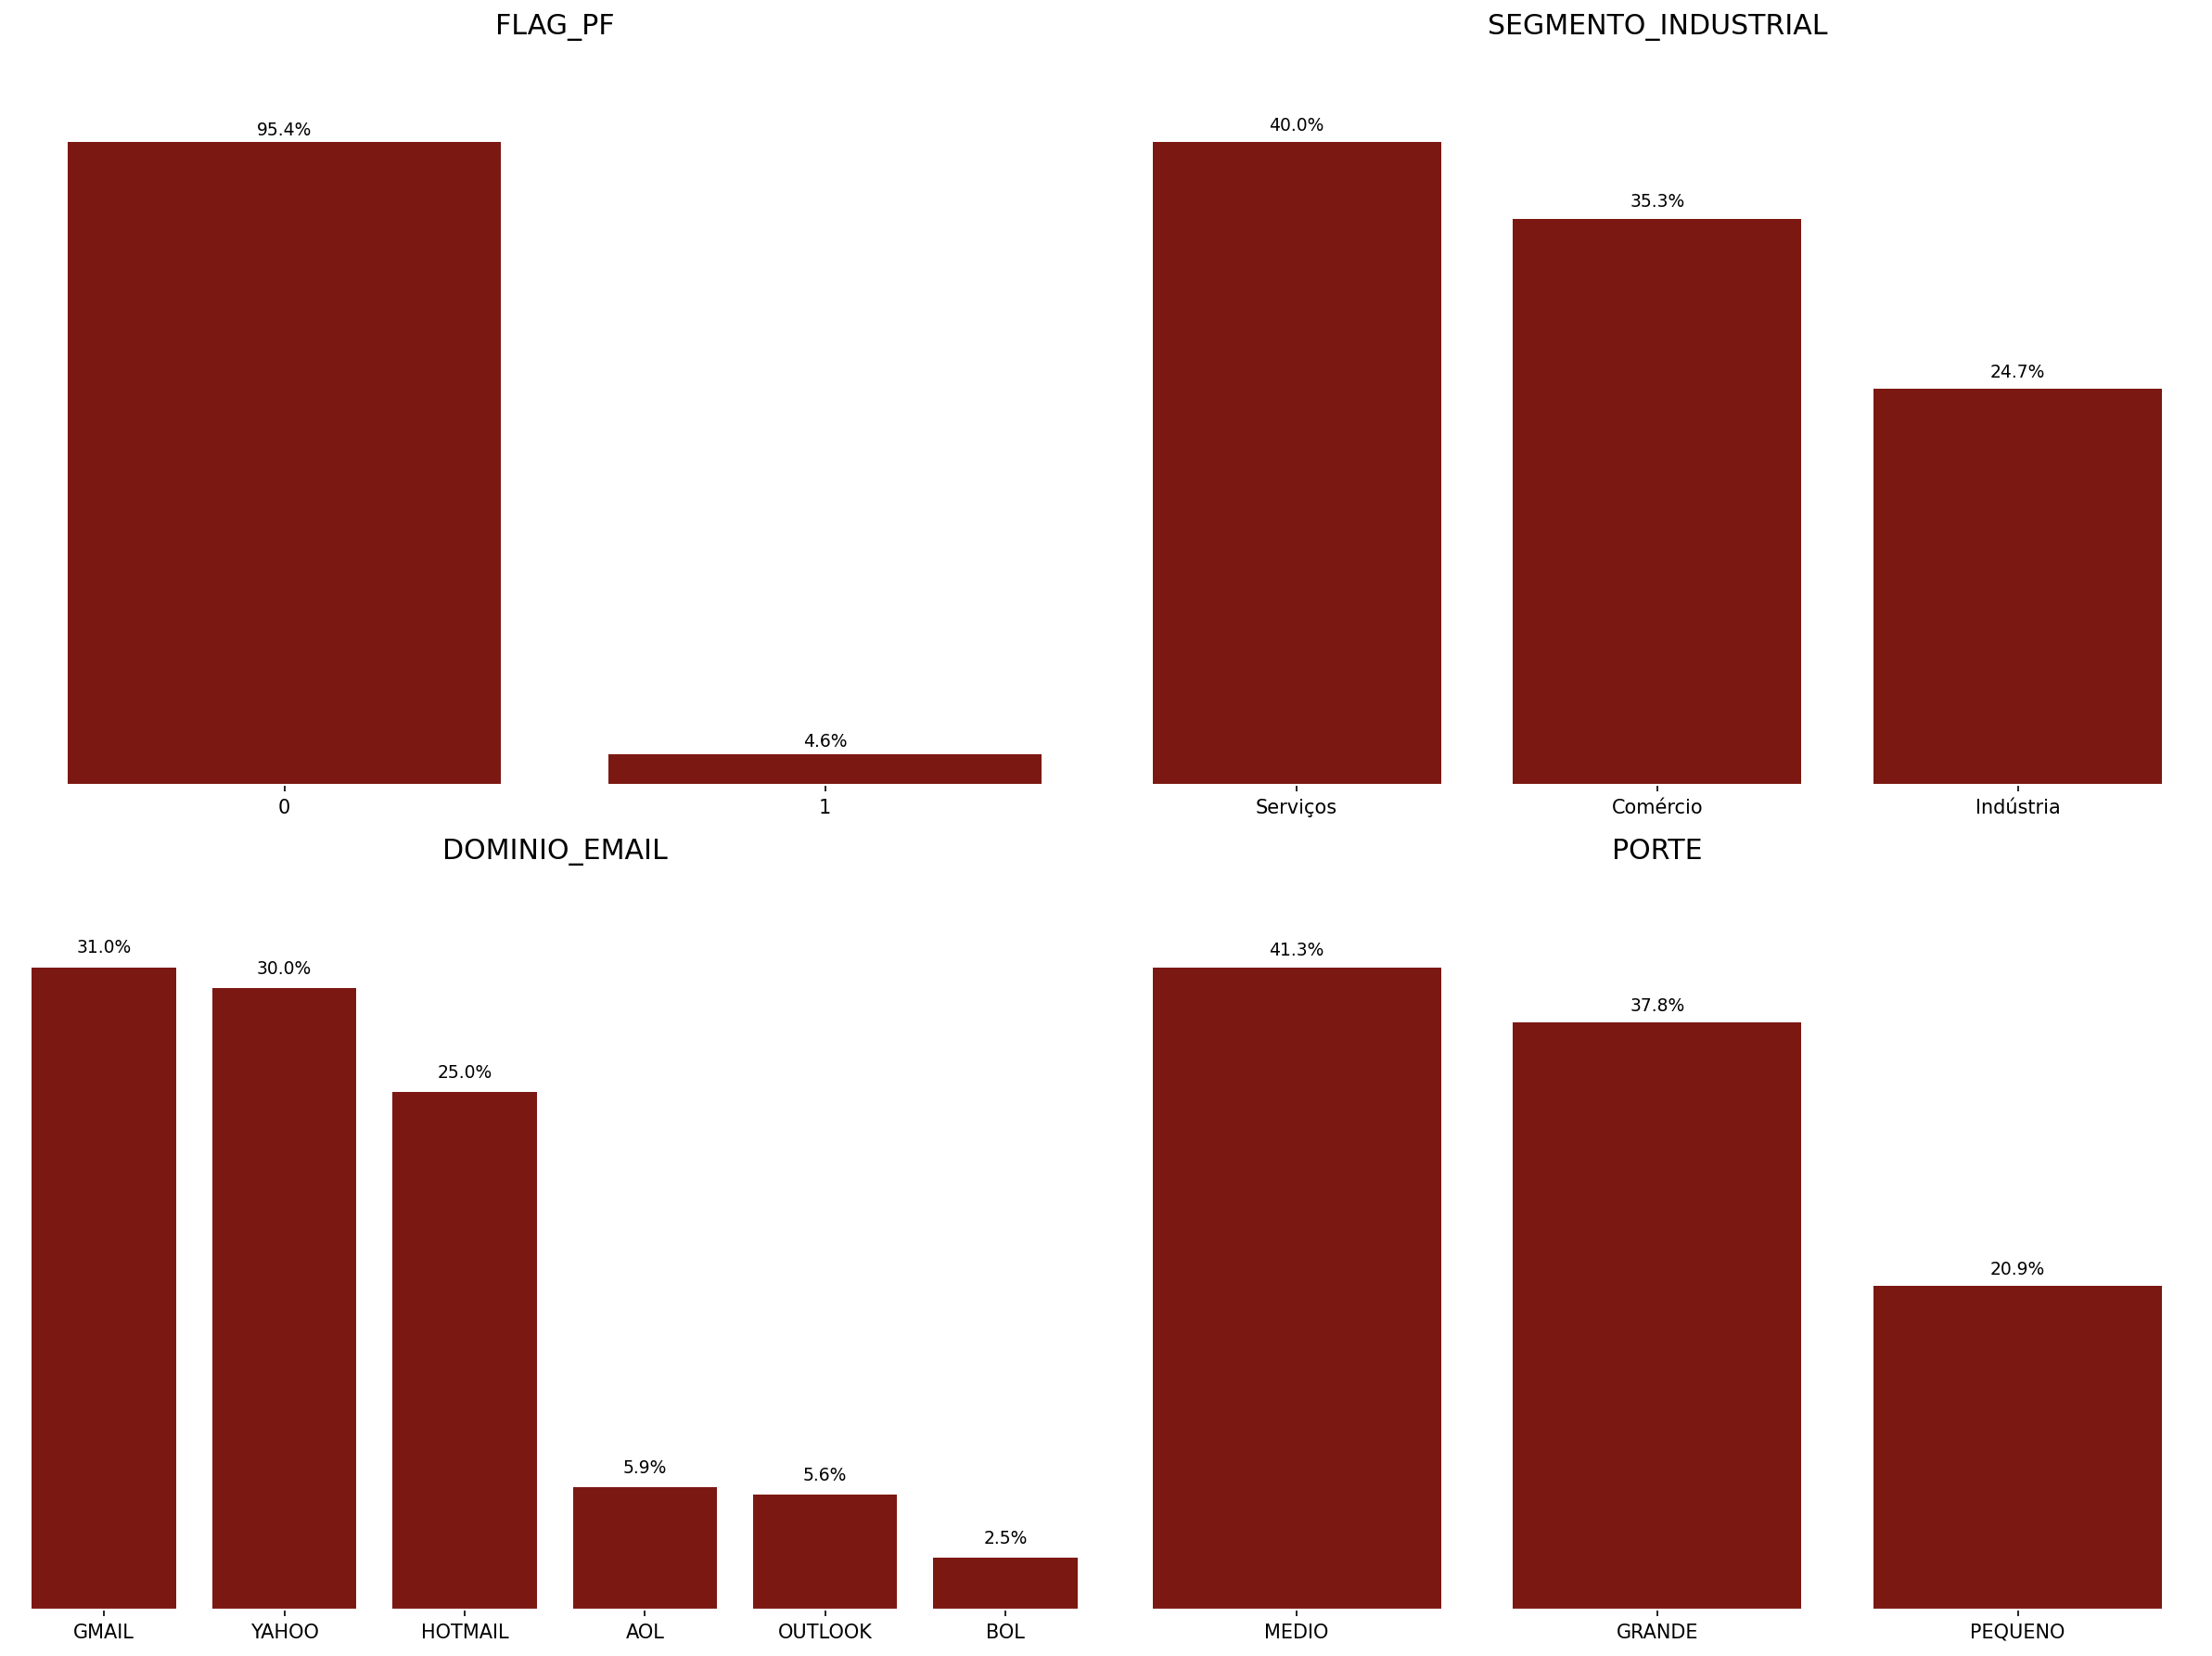

In [18]:
cat_feats = ['FLAG_PF', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL', 'PORTE']

n = len(cat_feats)
n_cols = 2
n_rows = (n + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, cat_feats):
    grouped = (
        train_bc[col]
        .value_counts(normalize=True)
        .mul(100)
        .reset_index()
    )
    grouped.columns = [col, 'pct']
    grouped = grouped.sort_values('pct', ascending=False)

    sns.barplot(data=grouped, x=col, y='pct', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticks([])

    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 0.5,
            f'{height:.1f}%',
            ha='center',
            va='bottom',
            fontsize=9
        )

    ax.set_ylim(0, grouped['pct'].max() * 1.15)
    ax.grid(False)

for j in range(len(cat_feats), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- Percebemos a presença massiva de clientes que não são pessoa física (empresas), cerca de pouco mais de 95%.
- O segmento industrial que mais está presente no conjunto de dados é o de Serviços, representando 40% dos clientes.
- Domínios de e-mail como: GMAIL, YAHOO e HOTMAIL são os mais presentes no conjunto de dados, somados representam 86% de todos os registros.
- Cerca de 79% dos clientes estão classificados com seu porte em médio e grande. Isso reforça a presença de contratos de médio-alto valor, o qual vimos durante a análise da base de pagamentos.

**4.3 Base info**

Esta base só possui variáveis numéricas, portanto, torna-se desnecessária a análise de variáveis categóricas.

In [19]:
base_info = DataUtils.read_data(file='processed/base_info.xlsx', file_type='xlsx')

base_info.head()

,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230976,2018-09-01,16913.0,NaN
1,8274986328479596544,2018-09-01,106430.0,141.0
2,345447888460137920,2018-09-01,707439.0,99.0
3,1003144834589372032,2018-09-01,239659.0,96.0
4,324916756972236032,2018-09-01,203123.0,103.0


Assim como na Base Cadastral, é essencial garantir que todos os registros correspondam com os ids presentes no conjunto de treinamentos de pagamentos, dessa forma, vamos novamente filtrar e garantir que essa correspondência ocorra.

In [20]:
train_bi = base_info[base_info['ID_CLIENTE'].isin(ids_train)]

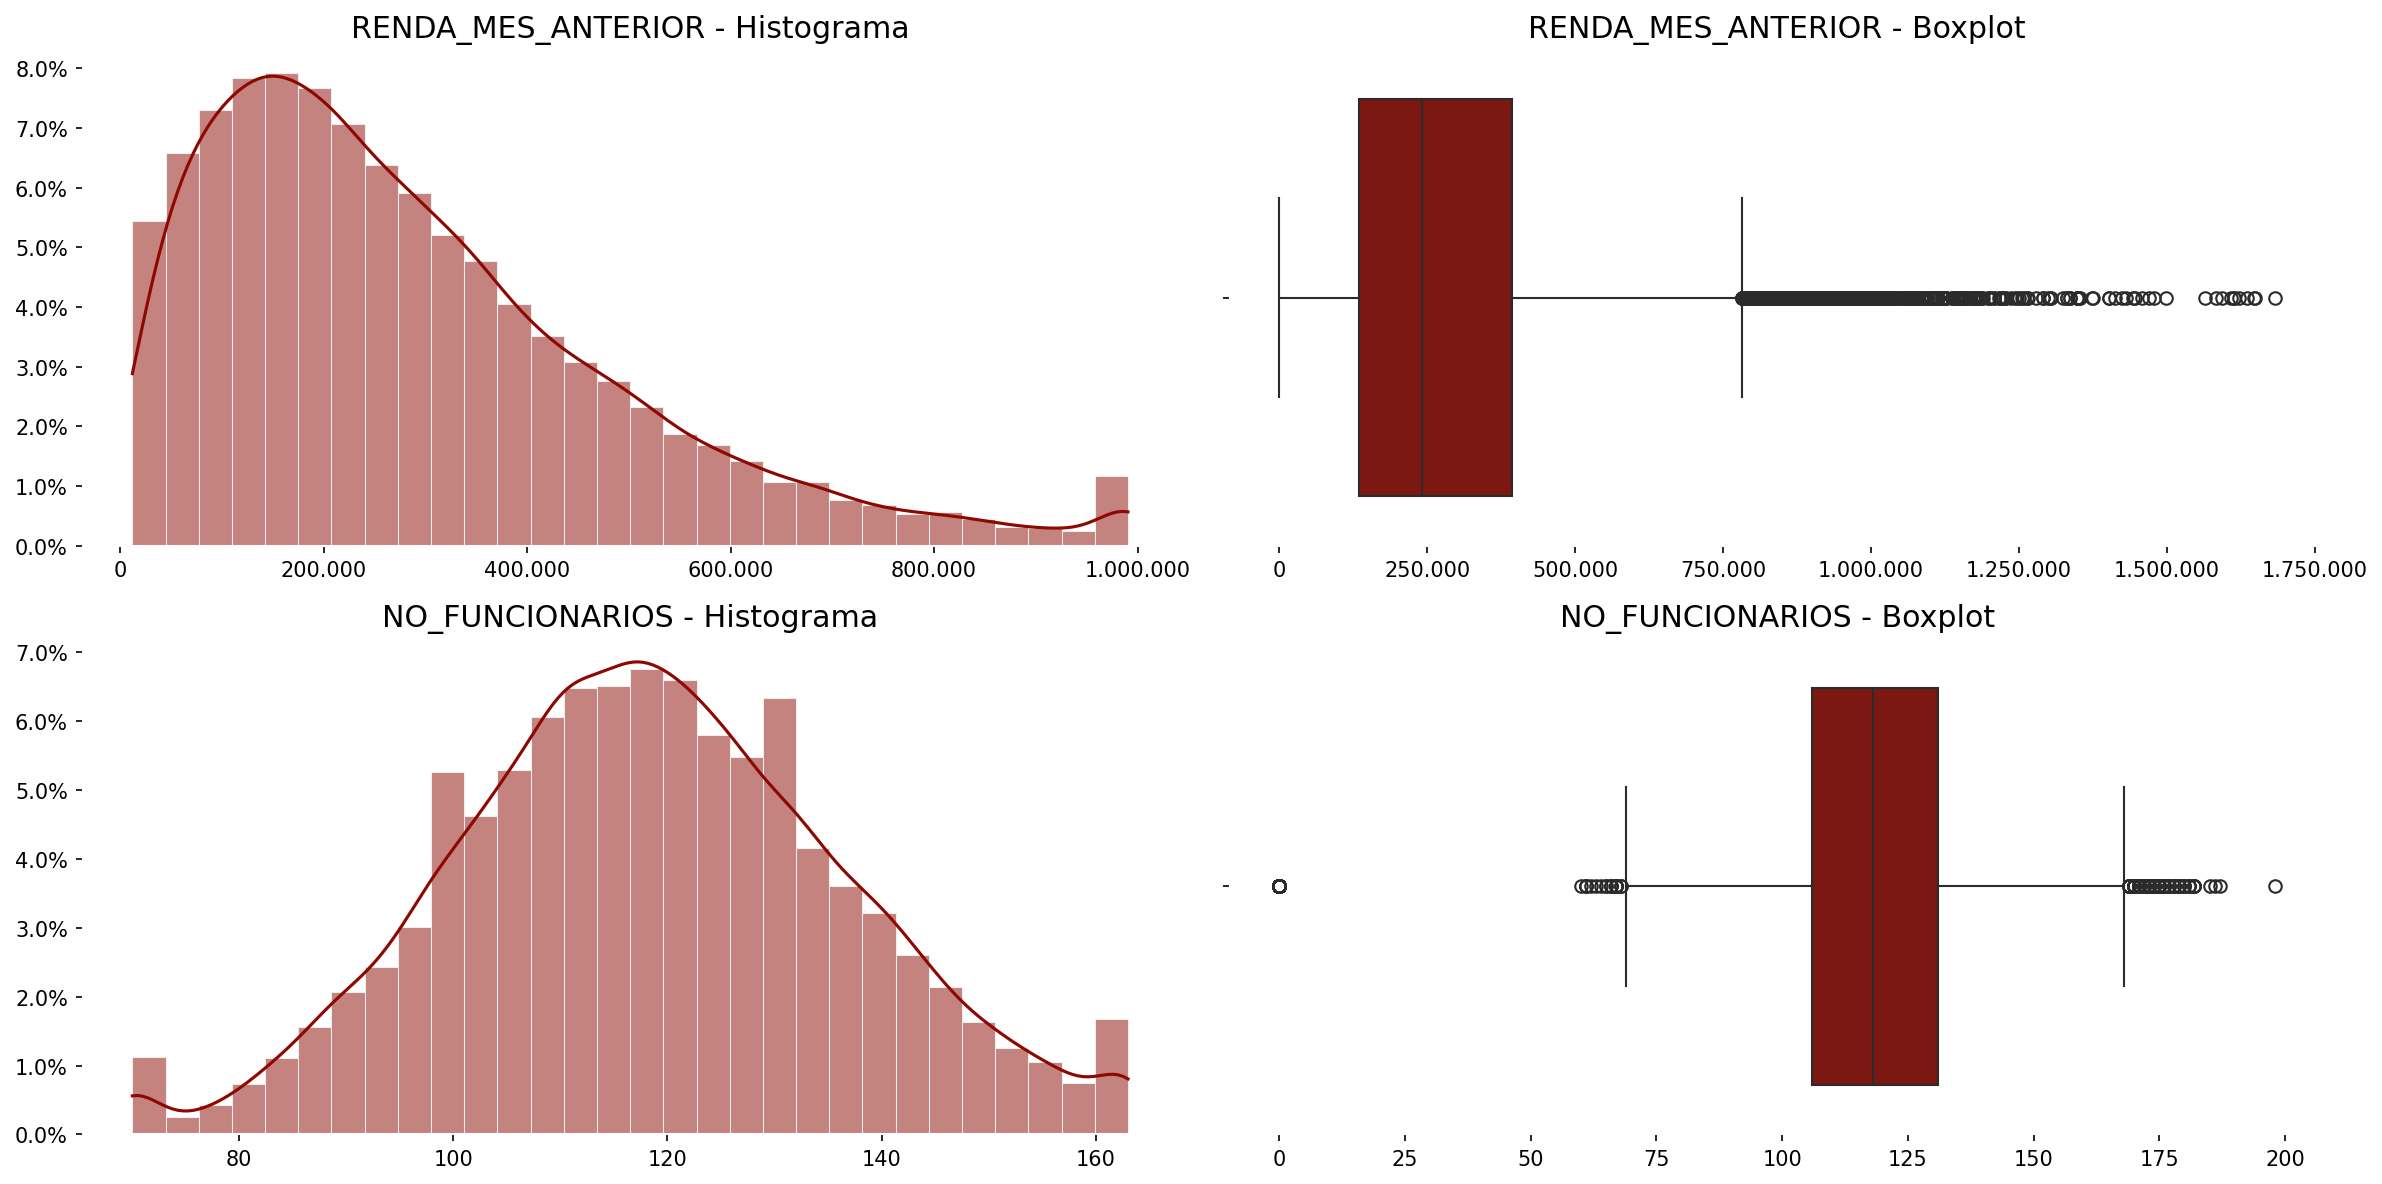

In [21]:
num_feats = ['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']
from matplotlib.ticker import FuncFormatter, PercentFormatter

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

for row, col in enumerate(num_feats):
    s = train_bi[col].dropna()
    lo = s.quantile(0.01)
    hi = s.quantile(0.99)
    s_clip = s.clip(lo, hi)

    ax_hist = axes[row, 0]
    sns.histplot(x=s_clip, kde=True, stat="probability", bins=30, ax=ax_hist, color="#8d0801")
    ax_hist.set_title(f"{col} - Histograma")
    ax_hist.set_xlabel('')
    ax_hist.set_ylabel('')
    ax_hist.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax_hist.grid(False)
    ax_hist.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:,.0f}".replace(",", ".")))

    ax_box = axes[row, 1]
    sns.boxplot(x=s, ax=ax_box, color="#8d0801", orient="h")
    ax_box.set_title(f"{col} - Boxplot")
    ax_box.set_xlabel('')
    ax_box.set_ylabel('')
    ax_box.grid(False)
    ax_box.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f"{x:,.0f}".replace(",", ".")))

plt.tight_layout()
plt.show()

- Percebemos a distorção na cauda a direita da variável de renda do mês anterior. Isso denota a presença de Outliers extremos, que podem chegar a 1.750.000. Entretanto, sua média fica por volta de 250.000,00.
- Notamos que grande parte dos clientes possuem ao menos mais de 50 funcionários. Mais uma vez reforçando o porte e tamanho dos contratos já discutidos.

!!! CHECAR OUTLIERS

### 5. Análise Multivariada

A partir da análise das variáveis em sua individualidade, analisaremos a sua relação com a variável alvo. Portanto, devemos juntar as informações presentes em ambos os datasets (base_cadastral e base_info) à base de pagamentos. 

In [22]:
final_df = pd.merge(
    left=pd.concat([train, test]).sort_values('SAFRA_REF'),
    right=base_cadastral,
    how='left',
    on='ID_CLIENTE'
).merge(
    on=['ID_CLIENTE', 'SAFRA_REF'],
    how='left',
    right=base_info
)

final_df.head()

,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA,DIAS_ATRASO,INADIMPLENTE,SET,DATA_CADASTRO,DDD,FLAG_PF,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
0,1661240395903230976,2018-08-01,2018-08-17,2018-09-06,2018-09-06,35516.41,6.99,0,0,train,2013-08-22,99,0,Serviços,YAHOO,PEQUENO,65,NaN,NaN
1,2025898153078563072,2018-08-01,2018-08-18,2018-09-18,2018-09-18,88567.80,6.99,0,0,train,2007-06-17,(3,0,Serviços,GMAIL,PEQUENO,36,NaN,NaN
2,2451708306555441152,2018-08-01,2018-08-18,2018-09-04,2018-09-04,57024.80,6.99,0,0,train,2000-08-15,41,0,Comércio,YAHOO,MEDIO,83,NaN,NaN
3,5301988619224057856,2018-08-01,2018-08-26,2018-09-11,2018-09-11,39089.52,6.99,0,0,train,2016-02-24,67,0,Indústria,GMAIL,NaN,79,NaN,NaN
4,382095722273502016,2018-08-01,2018-08-27,2018-09-26,2018-09-26,32494.20,5.99,0,0,train,2011-02-14,11,0,Indústria,YAHOO,PEQUENO,51,NaN,NaN


In [23]:
final_train = final_df[final_df['SET'] == 'train']
final_test = final_df[final_df['SET'] == 'test']

**Existem features que estão correlacionadas umas com as outras?**

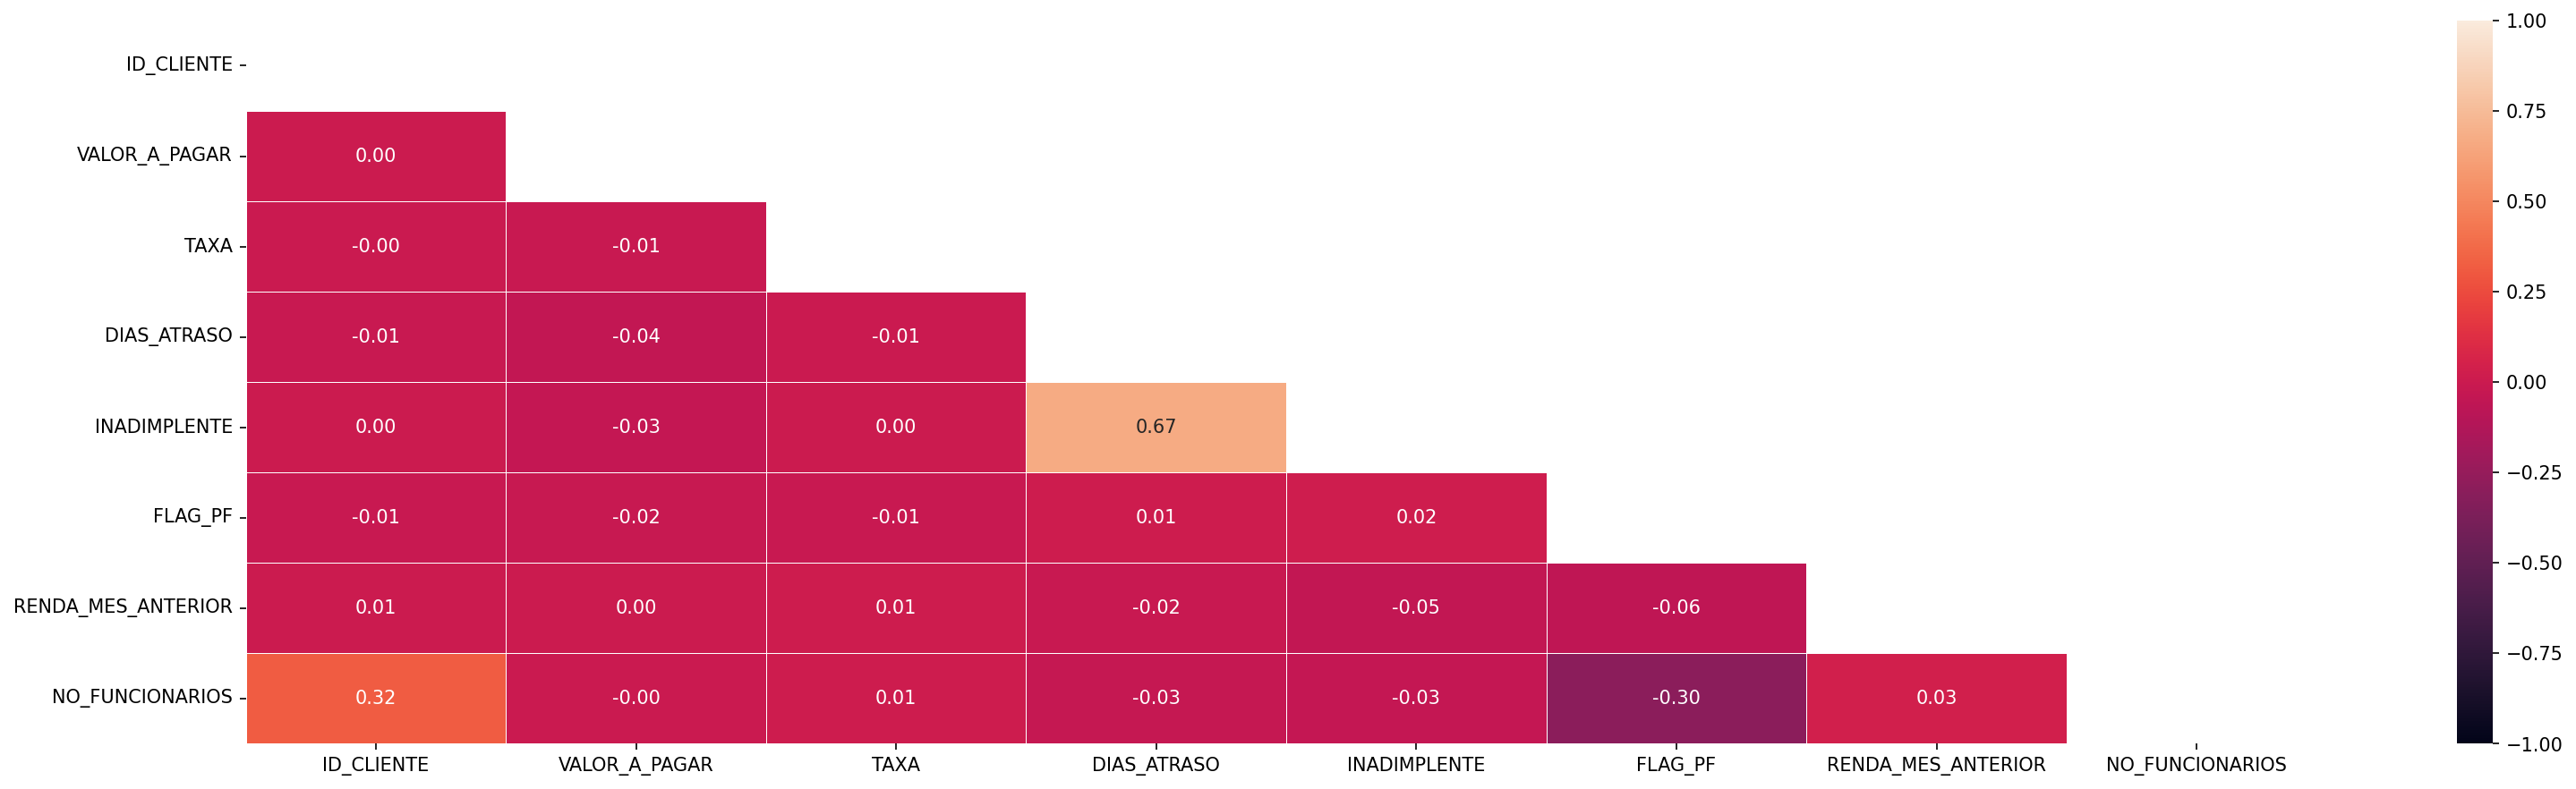

In [24]:
mask = np.zeros_like(final_train.corr(method='pearson', numeric_only=True), dtype=bool)
mask[np.triu_indices_from(mask)] = True

corr_matrix = final_train.corr(method='pearson', numeric_only=True)

plt.figure(figsize=(25, 7))
sns.heatmap(corr_matrix,linewidths=0.25, fmt=".2f", annot=True, vmin=-1, vmax=1, mask=mask)
plt.grid(False)
plt.show()

O heatmap Pearson mostra baixas correlações lineares entre as variáveis utilizadas e o target, o que é esperado em problemas de risco, onde os efeitos são não lineares e mais bem capturados por binning ou modelos de árvore.

A única correlação elevada é entre INADIMPLENTE e DIAS_ATRASO, reflexo direto da própria forma de construção do target. As demais correlações são baixas, indicando ausência de colinearidade linear relevante entre as variáveis.

#### **5.1 Variáveis categóricas**

**TAXA**

In [25]:
tax_df = DataUtils.woe_iv_table(
    data=final_train,
    feature='TAXA',
    target='INADIMPLENTE',
    bad_value=1,
    bins=None
)

tax_df

,n_obs,obs_proportion (%),good_row (%),bad_row (%),n_good,n_bad,good_col (%),bad_col (%),g/b,woe,iv
4.99,12532.0,20.24,92.190000,7.810000,11553.0,979.0,20.15,21.26,0.95,-0.05,0.00
5.99,20999.0,33.91,93.050000,6.950000,19539.0,1460.0,34.08,31.70,1.08,0.07,0.00
6.99,17889.0,28.89,92.680000,7.320000,16579.0,1310.0,28.92,28.45,1.02,0.02,0.00
8.99,6382.0,10.31,91.320000,8.680000,5828.0,554.0,10.17,12.03,0.85,-0.17,0.00
11.99,4129.0,6.67,92.690000,7.310000,3827.0,302.0,6.68,6.56,1.02,0.02,0.00
total,61931.0,100.00,92.564305,7.435695,57326.0,4605.0,100.00,100.00,NaN,NaN,0.01


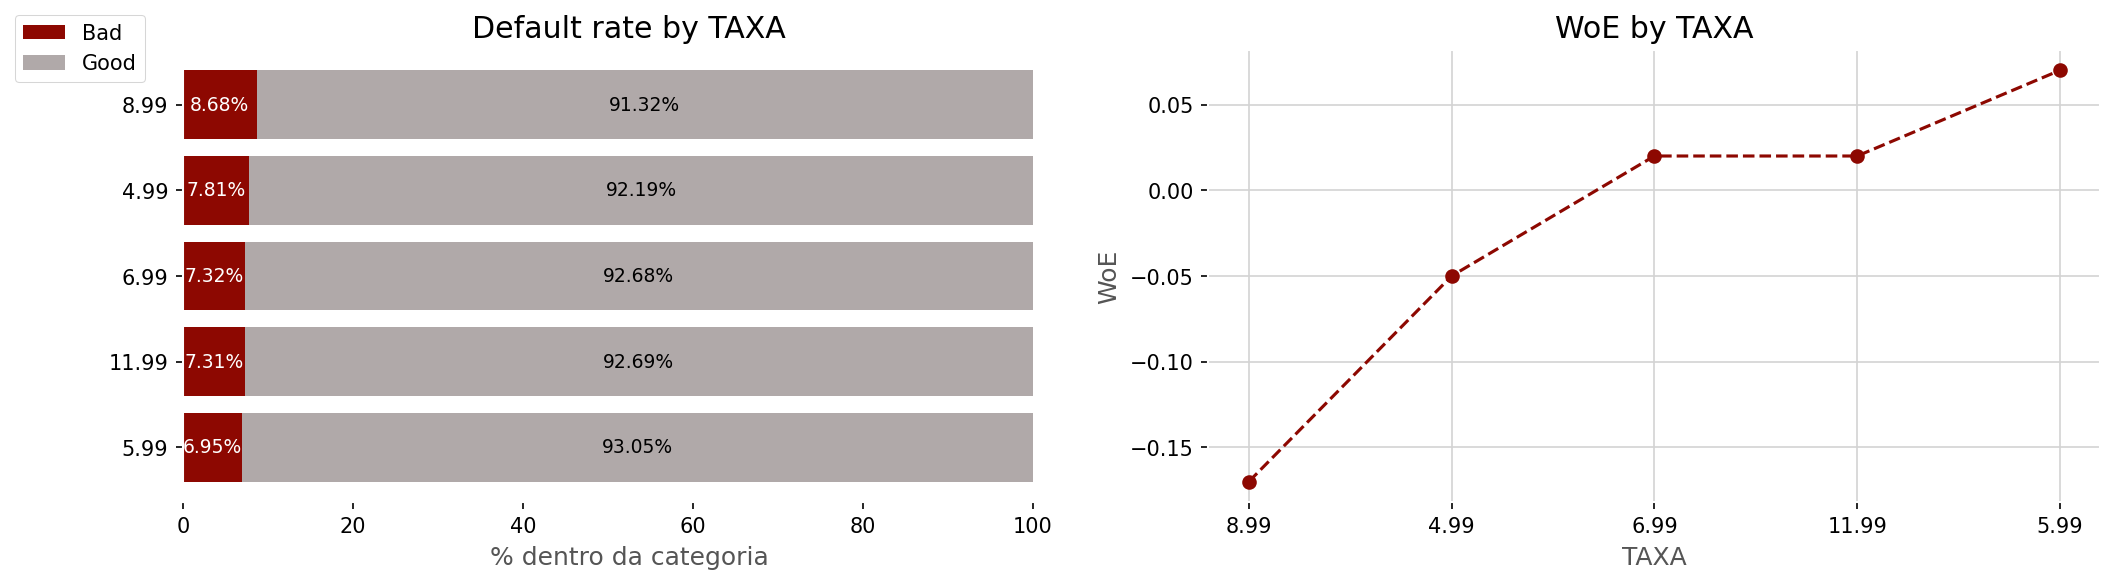

In [26]:
DataUtils.plot_default_woe(
    data=final_train,
    feature='TAXA',
    target='INADIMPLENTE',
)

A variável TAXA apresenta baixa capacidade de separação de risco.
As diferentes faixas de taxa mostram taxas de inadimplência muito próximas entre si, variando de apenas 6.95% a 8.68%.

O gráfico de WoE reforça essa conclusão: os valores variam entre –0.17 e +0.07, indicando separação fraca e ausência de monotonicidade.

Portanto, TAXA provavelmente terá IV baixo (<0.02) e deve ser considerada variável fraca ou até removida da modelagem, dependendo da estratégia.

**SEGMENTO INDUSTRIAL**

In [28]:
si_df = DataUtils.woe_iv_table(
    data=final_train,
    feature='SEGMENTO_INDUSTRIAL',
    target='INADIMPLENTE',
    bad_value=1,
    bins=None
)

si_df

,n_obs,obs_proportion (%),good_row (%),bad_row (%),n_good,n_bad,good_col (%),bad_col (%),g/b,woe,iv
Comércio,21328.0,35.09,94.530000,5.470000,20161.0,1167.0,35.84,25.83,1.39,0.33,0.03
Indústria,13798.0,22.70,91.670000,8.330000,12648.0,1150.0,22.48,25.45,0.88,-0.12,0.00
Serviços,25651.0,42.21,91.420000,8.580000,23450.0,2201.0,41.68,48.72,0.86,-0.16,0.01
total,60777.0,100.00,92.566267,7.433733,56259.0,4518.0,100.00,100.00,NaN,NaN,0.05


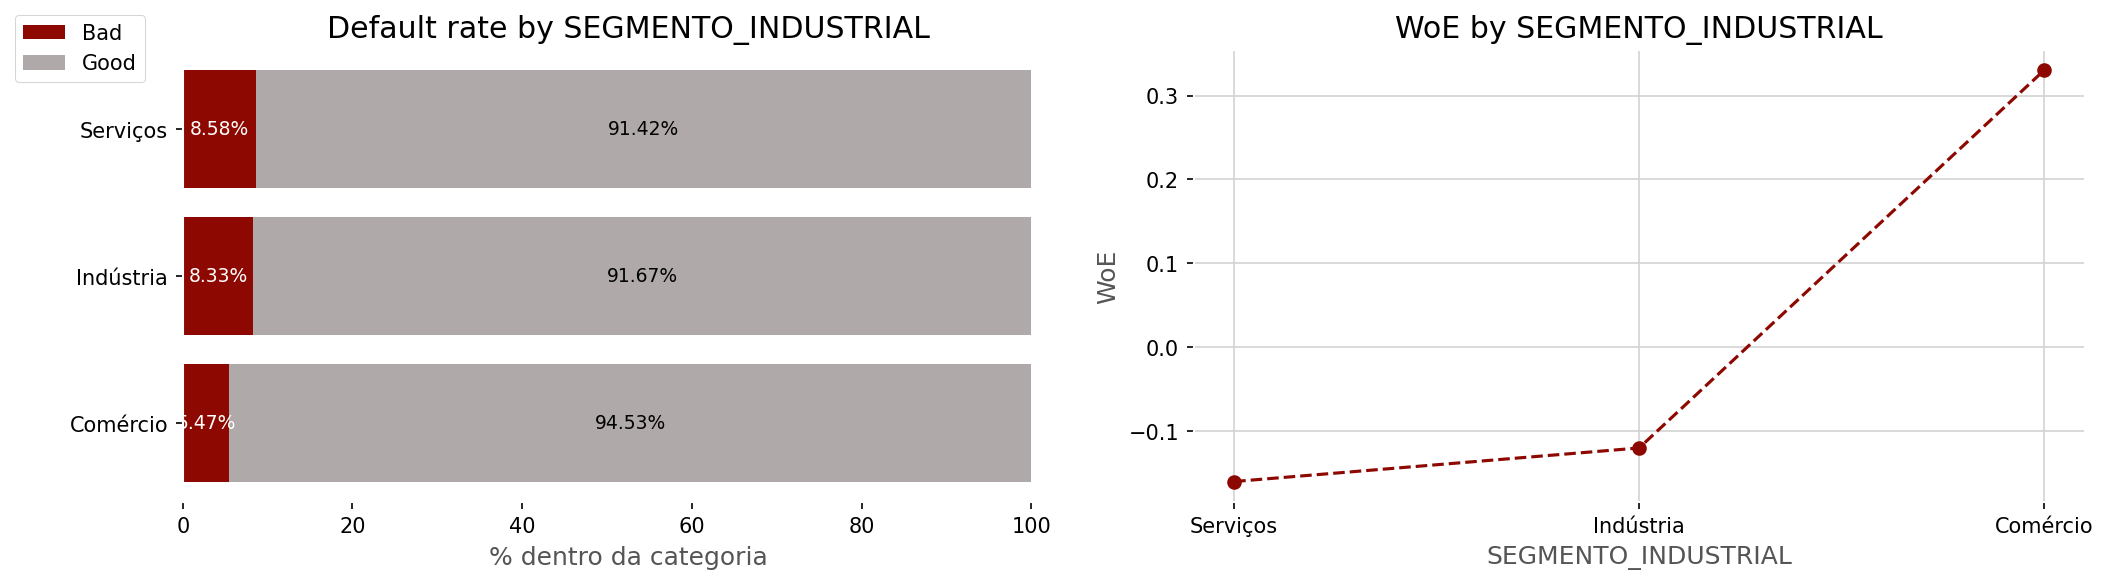

In [29]:
DataUtils.plot_default_woe(
    data=final_train,
    feature='SEGMENTO_INDUSTRIAL',
    target='INADIMPLENTE',
)

**CEP**

In [38]:
final_train_copy = final_train.copy()

final_train_copy['CEP_2_DIG'] = final_train_copy['CEP_2_DIG'].str[0]

cep_df = DataUtils.woe_iv_table(
    data=final_train_copy,
    feature='CEP_2_DIG',
    target='INADIMPLENTE',
    bad_value=1,
    bins=None
)

cep_df


,n_obs,obs_proportion (%),good_row (%),bad_row (%),n_good,n_bad,good_col (%),bad_col (%),g/b,woe,iv
1,10036.0,16.21,93.350000,6.650000,9369.0,667.0,16.34,14.48,1.13,0.12,0.00
2,6323.0,10.21,94.130000,5.870000,5952.0,371.0,10.38,8.06,1.29,0.25,0.01
3,9368.0,15.13,92.620000,7.380000,8677.0,691.0,15.14,15.01,1.01,0.01,0.00
4,4725.0,7.63,86.840000,13.160000,4103.0,622.0,7.16,13.51,0.53,-0.64,0.04
5,2651.0,4.28,88.610000,11.390000,2349.0,302.0,4.10,6.56,0.62,-0.47,0.01
6,6705.0,10.83,89.530000,10.470000,6003.0,702.0,10.47,15.24,0.69,-0.38,0.02
7,6841.0,11.05,89.710000,10.290000,6137.0,704.0,10.71,15.29,0.70,-0.36,0.02
8,10184.0,16.44,96.910000,3.090000,9869.0,315.0,17.22,6.84,2.52,0.92,0.10
9,5093.0,8.22,95.540000,4.460000,4866.0,227.0,8.49,4.93,1.72,0.54,0.02
n,5.0,0.01,20.000000,80.000000,1.0,4.0,0.00,0.09,0.02,-3.91,0.00


In [39]:
ddd =  DataUtils.woe_iv_table(
    data=final_train_copy,
    feature='DDD',
    target='INADIMPLENTE',
    bad_value=1,
    bins=None
)

ddd

,n_obs,obs_proportion (%),good_row (%),bad_row (%),n_good,n_bad,good_col (%),bad_col (%),g/b,woe,iv
(0,7.0,0.01,85.710000,14.290000,6.0,1.0,0.01,0.02,0.48,-0.74,0.00
(1,274.0,0.49,94.160000,5.840000,258.0,16.0,0.50,0.39,1.28,0.25,0.00
(2,159.0,0.28,96.860000,3.140000,154.0,5.0,0.30,0.12,2.45,0.90,0.00
(3,13.0,0.02,100.000000,0.000000,13.0,0.0,0.02,0.00,249759.85,12.43,0.00
(4,199.0,0.35,95.980000,4.020000,191.0,8.0,0.37,0.19,1.90,0.64,0.00
(5,61.0,0.11,95.080000,4.920000,58.0,3.0,0.11,0.07,1.54,0.43,0.00
(6,257.0,0.46,98.440000,1.560000,253.0,4.0,0.49,0.10,5.03,1.61,0.01
(8,149.0,0.27,93.290000,6.710000,139.0,10.0,0.27,0.24,1.10,0.10,0.00
(9,110.0,0.20,99.090000,0.910000,109.0,1.0,0.21,0.02,8.66,2.16,0.00
00,124.0,0.22,92.740000,7.260000,115.0,9.0,0.22,0.22,1.02,0.02,0.00


# Voltar, fazer análise geográfica